In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow
!pip install keras
!pip install opencv-python-headless

Mounted at /content/drive




*-- -- -- -- -- -- CARICAMENTO IMMAGINI -- -- -- -- -- --*







In [ ]:
import os
from glob import glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

In [ ]:
import os
from glob import glob
import random

def load_data(path, seed=42):
    random.seed(seed)  # Imposta un seed per la riproducibilità

    # Carica i percorsi dei file
    train_x = sorted(glob(os.path.join(path, "training", "train_x", "*.png")))
    train_y = sorted(glob(os.path.join(path, "training", "train_y", "*.png")))

    val_x = sorted(glob(os.path.join(path, "validation", "validation_x", "*.png")))
    val_y = sorted(glob(os.path.join(path, "validation", "validation_y", "*.png")))

    test_x = sorted(glob(os.path.join(path, "test", "test_x", "*.png")))
    test_y = sorted(glob(os.path.join(path, "test", "test_y", "*.png")))


    return (train_x, train_y), (val_x, val_y), (test_x, test_y)


In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    data_path = "/content/drive/MyDrive/Progetto/RETINA"
    (train_x, train_y), (val_x, val_y), (test_x, test_y) = load_data(data_path)


*-- -- -- -- -- -- CREAZIONE DELLA CLASSE RetinaDataset -- -- -- -- -- --*


In [ ]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

class RetinaDataset(Dataset):
    def __init__(self, image_paths, mask_paths, resize_to=(512, 512), patch_size=256, augment=False, use_patches=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resize_to = resize_to
        self.patch_size = patch_size
        self.augment = augment
        self.use_patches = use_patches
        self.transforms = self.get_transforms(augment)

    def __len__(self):
        if not self.use_patches:
            return len(self.image_paths)
        else:
            # Calcola il numero di patches per immagine considerando l'overlap
            step_size = self.patch_size - 128
            num_patches_x = (self.resize_to[0] - 128) // step_size
            num_patches_y = (self.resize_to[1] - 128) // step_size
            num_patches_per_image = num_patches_x * num_patches_y
            return len(self.image_paths) * num_patches_per_image

    def get_patches(self, image, mask, img_name):
          image = image.resize(self.resize_to)
          mask = mask.resize(self.resize_to)

          patches = []
          mask_patches = []
          patch_info = []

          step_size = self.patch_size - 128  # Calcolo dello step considerando l'overlap
          num_patches_x = (self.resize_to[0] - 128) // step_size
          num_patches_y = (self.resize_to[1] - 128) // step_size

          for i in range(num_patches_y):
              for j in range(num_patches_x):
                  x = j * step_size
                    y = i * step_size
                  patch = image.crop((x, y, x + self.patch_size, y + self.patch_size))
                  mask_patch = mask.crop((x, y, x + self.patch_size, y + self.patch_size))
                  patches.append(patch)
                  mask_patches.append(mask_patch)
                  patch_info.append(f"{img_name}_patch_{x}_{y}")

          return patches, mask_patches, patch_info



    def __getitem__(self, idx):
        if self.use_patches:
            # Calcola il numero di patches per dimensione
            step_size = self.patch_size - 128
            num_patches_x = (self.resize_to[0] - 128) // step_size
            num_patches_y = (self.resize_to[1] - 128) // step_size
            num_patches_per_image = num_patches_x * num_patches_y
            img_idx = idx // num_patches_per_image
            patch_idx = idx % num_patches_per_image

            image_path = self.image_paths[img_idx]
            mask_path = self.mask_paths[img_idx]
            img_name = os.path.splitext(os.path.basename(image_path))[0]  # Estrae il nome del file senza estensione

            image = Image.open(image_path).convert('RGB')
            r, g, b = image.split()  # Divide l'immagine nei suoi canali RGB
            image = g  # Utilizza solo il canale verde
            mask = Image.open(mask_path).convert('L')

            patches, mask_patches, patch_info = self.get_patches(image, mask, img_name)
            image, mask = patches[patch_idx], mask_patches[patch_idx]
            patch_name = patch_info[patch_idx]  # Recupera il nome della patch corrente

            if self.transforms:
                sample = self.transforms(image=np.array(image), mask=np.array(mask))
                image, mask = sample['image'], sample['mask']

        else:
            image_path = self.image_paths[idx]
            mask_path = self.mask_paths[idx]
            img_name = os.path.splitext(os.path.basename(image_path))[0]  # Estrae il nome del file senza estensione

            image = Image.open(image_path).convert('L')
            mask = Image.open(mask_path).convert('L')

            if self.transforms:
                sample = self.transforms(image=np.array(image), mask=np.array(mask))
                image, mask = sample['image'], sample['mask']
            patch_name = img_name  # Usa il nome dell'immagine originale se non si usano le patches

        image = image.clone().detach().to(dtype=torch.float32) / 255.0
        mask = mask.clone().detach().to(dtype=torch.float32) / 255.0

        return image, mask, patch_name

    def get_transforms(self, augment):
        if augment:
            return A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.2),
                A.Rotate(limit=45, p=0.5),

                ToTensorV2()


            ])
        else:
            return A.Compose([
                ToTensorV2()
            ])



In [ ]:
from torch.utils.data import DataLoader
import numpy as np
train_dataset = RetinaDataset(train_x, train_y, augment=True, use_patches=True)
val_dataset = RetinaDataset(val_x, val_y, augment=False, use_patches=True)
test_dataset = RetinaDataset(test_x, test_y, augment=False, use_patches=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

# Assicurati che la tupla restituita contenga 3 elementi (immagine, maschera, nome della patch) prima di eseguire questo
image_sample, mask_sample, patch_name = train_dataset[0]  # Prendiamo la prima immagine nel dataset di addestramento
print("Tipo dell'immagine:", type(image_sample))
print("Forma dell'immagine:", image_sample.shape)
print("Nome della patch:", patch_name)

#Calcoliamo il numero di patch per immagine con l'overlap di 128 pixel
num_patches_per_image = 9  # 9 patch per immagine, dato l'overlap di 128 pixel

# Iteriamo sulle prime 3 immagini e le loro patch
for img_idx in range(3):  # Per le prime 3 immagini
    print(f"Immagini {img_idx + 1}:")
    for patch_idx in range(num_patches_per_image):
        # Calcola l'indice globale della patch nel dataset
        global_patch_idx = img_idx * num_patches_per_image + patch_idx
        _, _, patch_name = train_dataset[global_patch_idx]  # Otteniamo la patch dal dataset
        print(f"Patch {patch_idx + 1}: {patch_name}")
    print("-" * 20)  # Separa le informazioni delle immagini per una migliore leggibilità


Tipo dell'immagine: <class 'torch.Tensor'>
Forma dell'immagine: torch.Size([1, 256, 256])
Nome della patch: 107_A_patch_0_0
Immagini 1:
Patch 1: 107_A_patch_0_0
Patch 2: 107_A_patch_128_0
Patch 3: 107_A_patch_256_0
Patch 4: 107_A_patch_0_128
Patch 5: 107_A_patch_128_128
Patch 6: 107_A_patch_256_128
Patch 7: 107_A_patch_0_256
Patch 8: 107_A_patch_128_256
Patch 9: 107_A_patch_256_256
--------------------
Immagini 2:
Patch 1: 112_A_patch_0_0
Patch 2: 112_A_patch_128_0
Patch 3: 112_A_patch_256_0
Patch 4: 112_A_patch_0_128
Patch 5: 112_A_patch_128_128
Patch 6: 112_A_patch_256_128
Patch 7: 112_A_patch_0_256
Patch 8: 112_A_patch_128_256
Patch 9: 112_A_patch_256_256
--------------------
Immagini 3:
Patch 1: 114_A_patch_0_0
Patch 2: 114_A_patch_128_0
Patch 3: 114_A_patch_256_0
Patch 4: 114_A_patch_0_128
Patch 5: 114_A_patch_128_128
Patch 6: 114_A_patch_256_128
Patch 7: 114_A_patch_0_256
Patch 8: 114_A_patch_128_256
Patch 9: 114_A_patch_256_256
--------------------


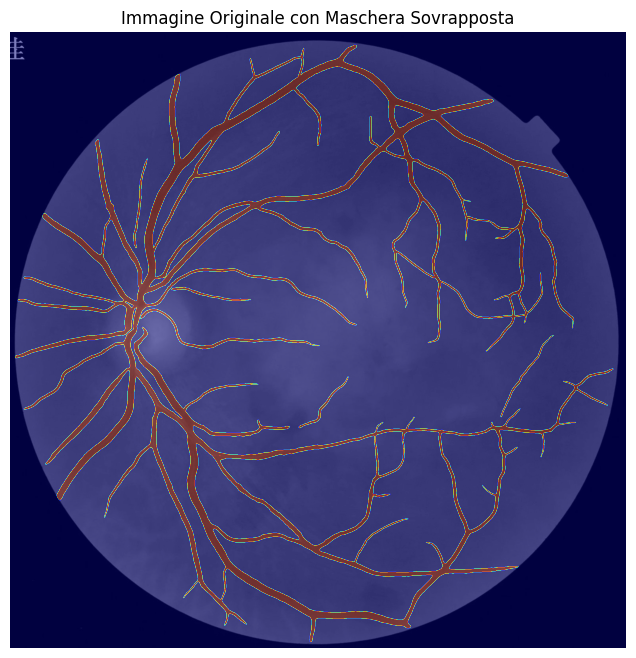

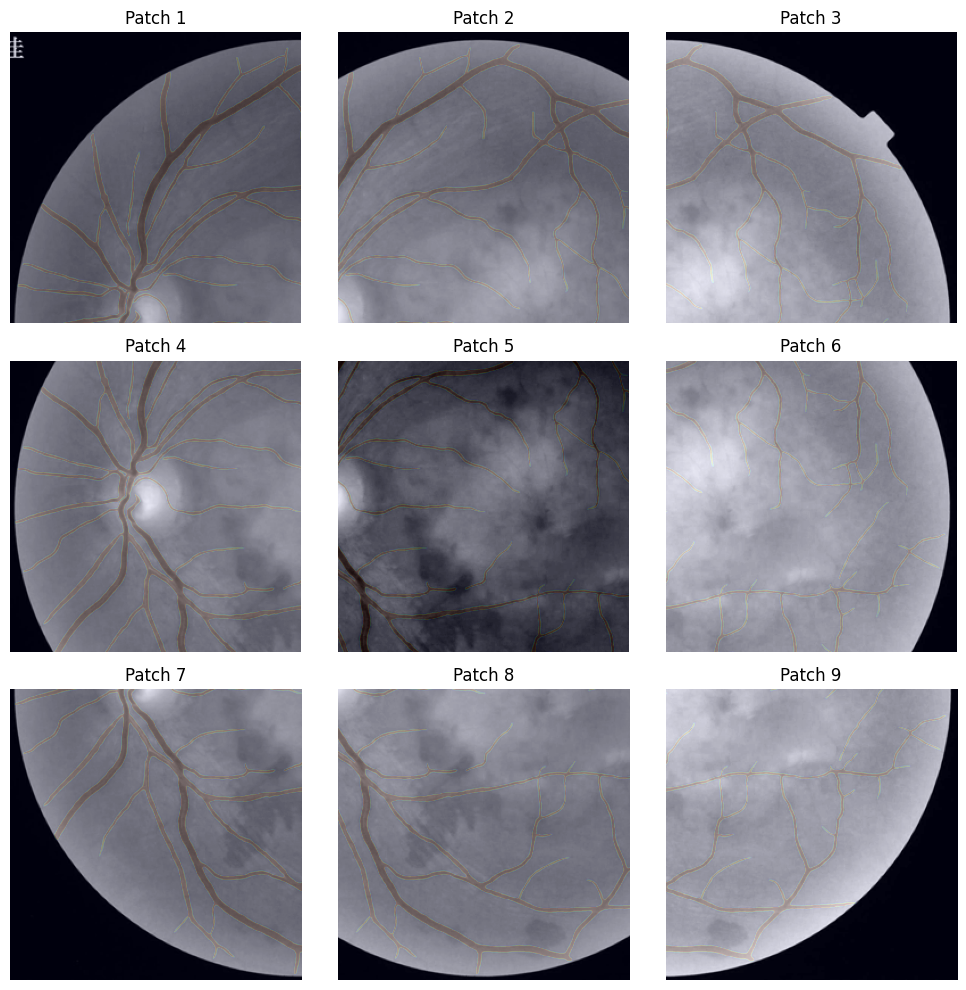

In [ ]:
import matplotlib.pyplot as plt

# Otteniamo l'immagine e la maschera originali per la prima immagine del validation set senza dividerle in patches
val_dataset = RetinaDataset(val_x, val_y, augment=False, use_patches=False)  # use_patches impostato su False per ottenere l'immagine intera
image_sample, mask_sample, _ = val_dataset[0]  # Ignoriamo il nome della patch

# Convertiamo i campioni da tensori PyTorch a array numpy e rimuoviamo le dimensioni aggiuntive
image_sample_np = image_sample.numpy().squeeze()
mask_sample_np = mask_sample.numpy().squeeze()

# Plot dell'immagine originale con la maschera sovrapposta
plt.figure(figsize=(8, 8))
plt.imshow(image_sample_np, cmap='gray')  # Immagine in scala di grigi
plt.imshow(mask_sample_np, alpha=0.5, cmap='jet')  # Sovrapposizione della maschera con opacità al 50%
plt.title("Immagine Originale con Maschera Sovrapposta")
plt.axis('off')
plt.show()

# Ora, ripristiniamo il dataset per utilizzare le patches e plotteremo le patches con le rispettive maschere
val_dataset = RetinaDataset(val_x, val_y, augment=False, use_patches=True)  # use_patches impostato su True per le patches
patches = []
mask_patches = []
for patch_idx in range(num_patches_per_image):
    patch_image, patch_mask, _ = val_dataset[patch_idx]
    patches.append(patch_image.numpy().squeeze())
    mask_patches.append(patch_mask.numpy().squeeze())

# Plot di tutte le patches con le rispettive maschere sovrapposte
fig, axs = plt.subplots(3, 3, figsize=(10, 10))  # Griglia 3x3 per le patches
for idx in range(9):
    ax = axs[idx // 3, idx % 3]
    ax.imshow(patches[idx], cmap='gray')  # Patch in scala di grigi
    ax.imshow(mask_patches[idx], alpha=0.1, cmap='jet')  # Sovrapposizione della maschera con opacità al 50%
    ax.set_title(f"Patch {idx+1}")
    ax.axis('off')
plt.tight_layout()
plt.show()


 -- -- -- -- -- UNET -- -- -- -- --

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()  # Funzione o per assicurare la riproducibilità

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4)
        x = self.conv1(torch.cat([x, x3], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x2], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, x1], dim=1))
        logits = self.outc(x)
        return logits


In [ ]:
# Inizializza la rete U-Net
model = UNet(n_channels=1, n_classes=1)


In [ ]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import torch.nn as nn


# Define Dice Loss. Since it's a loss function, each operation must be differentiable so we can backpropagate the gradients. To do this we use torch native functions.
def dice_loss(outputs, labels, eps=1e-7):
    intersection = torch.sum(outputs * labels)
    union = torch.sum(outputs) + torch.sum(labels)
    dice_score = 2.0 * intersection / (union + eps)
    return 1.0 - dice_score

criterion = dice_loss

# Define optimizer with weight decay
optimizer = Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Define learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min')


In [ ]:
def IOU(outputs, labels):
    """
    Compute IOU for both PyTorch tensors and NumPy arrays.
    """

    # Convert PyTorch tensors to NumPy if necessary
    if isinstance(outputs, torch.Tensor):
        outputs = outputs.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()

    # Check if the output and labels are of the same size
    if outputs.shape != labels.shape:
        raise ValueError(f"Expected output size ({outputs.shape}) to be same as target size ({labels.shape})")

    # Convert labels to boolean array
    labels = labels.astype(bool)

    # Threshold outputs to obtain binary values
    outputs = outputs > 0.5

    # Compute intersection and union
    intersection = np.logical_and(labels, outputs)
    union = np.logical_or(labels, outputs)

    # Compute IOU
    iou = np.sum(intersection) / np.sum(union)

    return iou


In [ ]:
# Numero di batch nei DataLoader
num_batches_train = len(train_loader)
num_batches_val = len(val_loader)
num_batches_test = len(test_loader)

print(f"Numero di batch in Train Loader: {num_batches_train}")
print(f"Numero di batch in Validation Loader: {num_batches_val}")
print(f"Numero di batch in Test Loader: {num_batches_test}")

# Numero totale di elementi (assumendo ogni batch tranne l'ultimo sia pieno)
total_items_train = len(train_loader.dataset)
total_items_val = len(val_loader.dataset)
total_items_test = len(test_loader.dataset)
print(f"Numero totale di elementi in Train Loader: {total_items_train}")
print(f"Numero totale di elementi in Validation Loader: {total_items_val}")
print(f"Numero totale di elementi in Test Loader: {total_items_test}")

Numero di batch in Train Loader: 169
Numero di batch in Validation Loader: 23
Numero di batch in Test Loader: 34
Numero totale di elementi in Train Loader: 1350
Numero totale di elementi in Validation Loader: 180
Numero totale di elementi in Test Loader: 270


**-- -- -- -- -- TRAINING -- -- -- -- --**

In [ ]:
# Training settings
n_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
working_folder= "/content/drive/MyDrive/Progetto/RETINA"

# Move model to GPU
model = model.to(device)

# Start training loop

early_stopping_patience = 7
epochs_since_improvement = 0
best_val_loss = float('inf')
best_iou_score = 0.0

# define two lists to store the training and validation losses
train_losses = []
val_losses = []

for epoch in range(n_epochs):

    # Training phase
    model.train()

    # Initialize running loss to 0
    running_loss = 0.0

    # Add a progress bar for the training loop. This is done applying the function tqdm to the train_loader object
    train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{n_epochs}", unit="batch")

    for images, masks, patch_names in train_progress_bar:

        # Move images and masks to device
        images, masks = images.to(device), masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images).sigmoid().squeeze()

        # Compute loss
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

        # Update progress bar
        train_progress_bar.set_postfix(loss=running_loss / ((train_progress_bar.n + 1) * train_loader.batch_size))

    train_loss = running_loss / len(train_loader.dataset)

    # store the training loss in the list
    train_losses.append(train_loss)

    # Validation phase
    model.eval()

    # Initialize running loss and IOU score to 0
    running_loss = 0.0
    running_iou_score = 0.0

    # Add a progress bar for the validation loop
    val_progress_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{n_epochs}", unit="batch")

    with torch.no_grad():
        for images, masks, patch_names in val_progress_bar:

            # Move images and masks to device, compute outputs and loss
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images)) # sigmoid to convert the network output to probabilities between 0 and 1, the squeeze function removes the extra dimension
            outputs = outputs.squeeze()
            masks = masks.squeeze()
            loss = criterion(outputs, masks)

            # Update running loss and IOU score
            running_loss += loss.item() * images.size(0)
            running_iou_score += IOU(outputs, masks).item() * images.size(0)

            val_progress_bar.set_postfix(loss=running_loss / ((val_progress_bar.n + 1) * val_loader.batch_size))

    # Compute validation loss and IOU score
    val_loss = running_loss / len(val_loader.dataset)
    iou_score = running_iou_score / len(val_loader.dataset)

    # store the validation loss in the list
    val_losses.append(val_loss)

     # Check for improvement
    if val_loss < best_val_loss:
        print(f'Modello migliorato da {best_val_loss:.4f} a {val_loss:.4f}. Salvataggio in corso...')
        best_val_loss = val_loss
        best_iou_score = iou_score
        epochs_since_improvement = 0

        # Salva il modello
        model_dir = os.path.join(working_folder,'models')
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(model.state_dict(), os.path.join(model_dir,'model256over.pth'))
        print(f'Modello salvato: epoca {epoch+1} con loss di validazione {best_val_loss:.4f} e IOU di validazione {best_iou_score:.4f}')
    else:
        epochs_since_improvement += 1

    # Early stopping
    if epochs_since_improvement >= early_stopping_patience:
        print(f'Interruzione anticipata attivata dopo {epoch + 1} epoche.')
        break



        # After all epochs, plot and save the training and validation losses
    loss_dir = os.path.join(working_folder, 'losses')
    if not os.path.exists(loss_dir):
        os.makedirs(loss_dir)

    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Training/Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(loss_dir, "final_loss_plot256over.png"))
    plt.close()

    # Update learning rate
    scheduler.step(val_loss)

    # Save model if validation loss has decreased in a folder called "models"
    if val_loss < best_val_loss:

        # update the best validation loss and IOU score
        best_val_loss = val_loss
        best_iou_score = iou_score

        # create the folder if it does not exist
        model_dir = os.path.join(working_folder,'models')
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        # save the model
        torch.save(model.state_dict(), os.path.join(model_dir,'model256over.pth'))
        print(f'Model saved at epoch {epoch+1} with validation loss of {best_val_loss:.4f} and validation IOU of {best_iou_score:.4f}')

    print(f'Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation IOU: {iou_score:.4f}')


Validation Epoch 1/50: 100%|██████████| 23/23 [00:45<00:00,  1.97s/batch, loss=0.372]


Modello migliorato da inf a 0.3800. Salvataggio in corso...
Modello salvato: epoca 1 con loss di validazione 0.3800 e IOU di validazione 0.6123
Epoch 1/50, Training Loss: 0.5390, Validation Loss: 0.3800, Validation IOU: 0.6123


Validation Epoch 2/50: 100%|██████████| 23/23 [00:37<00:00,  1.64s/batch, loss=0.187]


Modello migliorato da 0.3800 a 0.1908. Salvataggio in corso...
Modello salvato: epoca 2 con loss di validazione 0.1908 e IOU di validazione 0.6545
Epoch 2/50, Training Loss: 0.2759, Validation Loss: 0.1908, Validation IOU: 0.6545


Validation Epoch 3/50: 100%|██████████| 23/23 [00:38<00:00,  1.68s/batch, loss=0.169]


Modello migliorato da 0.1908 a 0.1725. Salvataggio in corso...
Modello salvato: epoca 3 con loss di validazione 0.1725 e IOU di validazione 0.6765
Epoch 3/50, Training Loss: 0.2068, Validation Loss: 0.1725, Validation IOU: 0.6765


Validation Epoch 4/50: 100%|██████████| 23/23 [00:39<00:00,  1.72s/batch, loss=0.152]


Modello migliorato da 0.1725 a 0.1551. Salvataggio in corso...
Modello salvato: epoca 4 con loss di validazione 0.1551 e IOU di validazione 0.6901
Epoch 4/50, Training Loss: 0.1919, Validation Loss: 0.1551, Validation IOU: 0.6901


Validation Epoch 5/50: 100%|██████████| 23/23 [00:37<00:00,  1.65s/batch, loss=0.158]


Epoch 5/50, Training Loss: 0.1806, Validation Loss: 0.1616, Validation IOU: 0.5980


Validation Epoch 6/50: 100%|██████████| 23/23 [00:37<00:00,  1.61s/batch, loss=0.145]


Modello migliorato da 0.1551 a 0.1486. Salvataggio in corso...
Modello salvato: epoca 6 con loss di validazione 0.1486 e IOU di validazione 0.6144
Epoch 6/50, Training Loss: 0.1723, Validation Loss: 0.1486, Validation IOU: 0.6144


Validation Epoch 7/50: 100%|██████████| 23/23 [00:38<00:00,  1.68s/batch, loss=0.143]


Modello migliorato da 0.1486 a 0.1458. Salvataggio in corso...
Modello salvato: epoca 7 con loss di validazione 0.1458 e IOU di validazione 0.6419
Epoch 7/50, Training Loss: 0.1714, Validation Loss: 0.1458, Validation IOU: 0.6419


Validation Epoch 8/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.15]


Epoch 8/50, Training Loss: 0.1702, Validation Loss: 0.1538, Validation IOU: 0.6228


Validation Epoch 9/50: 100%|██████████| 23/23 [00:36<00:00,  1.59s/batch, loss=0.138]


Modello migliorato da 0.1458 a 0.1414. Salvataggio in corso...
Modello salvato: epoca 9 con loss di validazione 0.1414 e IOU di validazione 0.6415
Epoch 9/50, Training Loss: 0.1696, Validation Loss: 0.1414, Validation IOU: 0.6415


Validation Epoch 10/50: 100%|██████████| 23/23 [00:38<00:00,  1.65s/batch, loss=0.137]


Modello migliorato da 0.1414 a 0.1401. Salvataggio in corso...
Modello salvato: epoca 10 con loss di validazione 0.1401 e IOU di validazione 0.6610
Epoch 10/50, Training Loss: 0.1671, Validation Loss: 0.1401, Validation IOU: 0.6610


Validation Epoch 11/50: 100%|██████████| 23/23 [00:37<00:00,  1.61s/batch, loss=0.155]


Epoch 11/50, Training Loss: 0.1655, Validation Loss: 0.1584, Validation IOU: 0.5857


Validation Epoch 12/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.148]


Epoch 12/50, Training Loss: 0.1636, Validation Loss: 0.1513, Validation IOU: 0.6160


Validation Epoch 13/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.136]


Modello migliorato da 0.1401 a 0.1388. Salvataggio in corso...
Modello salvato: epoca 13 con loss di validazione 0.1388 e IOU di validazione 0.6566
Epoch 13/50, Training Loss: 0.1656, Validation Loss: 0.1388, Validation IOU: 0.6566


Validation Epoch 14/50: 100%|██████████| 23/23 [00:37<00:00,  1.63s/batch, loss=0.127]


Modello migliorato da 0.1388 a 0.1294. Salvataggio in corso...
Modello salvato: epoca 14 con loss di validazione 0.1294 e IOU di validazione 0.7001
Epoch 14/50, Training Loss: 0.1629, Validation Loss: 0.1294, Validation IOU: 0.7001


Validation Epoch 15/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.142]


Epoch 15/50, Training Loss: 0.1647, Validation Loss: 0.1448, Validation IOU: 0.6121


Validation Epoch 16/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.143]


Epoch 16/50, Training Loss: 0.1646, Validation Loss: 0.1458, Validation IOU: 0.6408


Validation Epoch 17/50: 100%|██████████| 23/23 [00:37<00:00,  1.62s/batch, loss=0.132]


Epoch 17/50, Training Loss: 0.1616, Validation Loss: 0.1347, Validation IOU: 0.7150


Validation Epoch 18/50: 100%|██████████| 23/23 [00:38<00:00,  1.67s/batch, loss=0.145]


Epoch 18/50, Training Loss: 0.1615, Validation Loss: 0.1483, Validation IOU: 0.6000


Validation Epoch 19/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.126]


Modello migliorato da 0.1294 a 0.1288. Salvataggio in corso...
Modello salvato: epoca 19 con loss di validazione 0.1288 e IOU di validazione 0.6635
Epoch 19/50, Training Loss: 0.1593, Validation Loss: 0.1288, Validation IOU: 0.6635


Validation Epoch 20/50: 100%|██████████| 23/23 [00:36<00:00,  1.60s/batch, loss=0.154]


Epoch 20/50, Training Loss: 0.1613, Validation Loss: 0.1573, Validation IOU: 0.6035


Validation Epoch 21/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.133]


Epoch 21/50, Training Loss: 0.1610, Validation Loss: 0.1365, Validation IOU: 0.6364


Validation Epoch 22/50: 100%|██████████| 23/23 [00:36<00:00,  1.59s/batch, loss=0.129]


Epoch 22/50, Training Loss: 0.1593, Validation Loss: 0.1316, Validation IOU: 0.6761


Validation Epoch 23/50: 100%|██████████| 23/23 [00:37<00:00,  1.65s/batch, loss=0.127]


Epoch 23/50, Training Loss: 0.1592, Validation Loss: 0.1296, Validation IOU: 0.6763


Validation Epoch 24/50: 100%|██████████| 23/23 [00:36<00:00,  1.58s/batch, loss=0.139]


Epoch 24/50, Training Loss: 0.1578, Validation Loss: 0.1422, Validation IOU: 0.6256


Validation Epoch 25/50: 100%|██████████| 23/23 [00:38<00:00,  1.65s/batch, loss=0.135]


Epoch 25/50, Training Loss: 0.1599, Validation Loss: 0.1377, Validation IOU: 0.6295


Validation Epoch 26/50: 100%|██████████| 23/23 [00:37<00:00,  1.65s/batch, loss=0.124]


Modello migliorato da 0.1288 a 0.1270. Salvataggio in corso...
Modello salvato: epoca 26 con loss di validazione 0.1270 e IOU di validazione 0.6687
Epoch 26/50, Training Loss: 0.1591, Validation Loss: 0.1270, Validation IOU: 0.6687


Validation Epoch 27/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.127]


Epoch 27/50, Training Loss: 0.1588, Validation Loss: 0.1296, Validation IOU: 0.6975


Validation Epoch 28/50: 100%|██████████| 23/23 [00:36<00:00,  1.60s/batch, loss=0.133]


Epoch 28/50, Training Loss: 0.1598, Validation Loss: 0.1362, Validation IOU: 0.6322


Validation Epoch 29/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.127]


Epoch 29/50, Training Loss: 0.1575, Validation Loss: 0.1302, Validation IOU: 0.6532


Validation Epoch 30/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.148]


Epoch 30/50, Training Loss: 0.1579, Validation Loss: 0.1517, Validation IOU: 0.5987


Validation Epoch 31/50: 100%|██████████| 23/23 [00:36<00:00,  1.61s/batch, loss=0.126]


Epoch 31/50, Training Loss: 0.1586, Validation Loss: 0.1284, Validation IOU: 0.6726


Validation Epoch 32/50: 100%|██████████| 23/23 [00:38<00:00,  1.66s/batch, loss=0.131]


Epoch 32/50, Training Loss: 0.1577, Validation Loss: 0.1341, Validation IOU: 0.6244


Validation Epoch 33/50: 100%|██████████| 23/23 [00:36<00:00,  1.59s/batch, loss=0.125]

Interruzione anticipata attivata dopo 33 epoche.


In [ ]:
from PIL import Image
import os
import torch
import numpy as np


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize your model here
model = UNet(n_channels=1, n_classes=1).to(device)

# Path to the folder where your model is saved
working_folder = '/content/drive/MyDrive/Progetto/RETINA'
model_dir = os.path.join(working_folder, 'models')

# Load the model weights
model_path = os.path.join(model_dir, 'model256over.pth')
model.load_state_dict(torch.load(model_path, map_location=device))


def test_model(test_loader, model, criterion, device, save_folder, subset, save_predictions=False):
    model.eval()
    running_loss = 0.0
    running_iou_score = 0.0

    if save_predictions:
        # Crea la cartella per salvare le previsioni, se non esiste
        save_folder = os.path.join(save_folder, subset)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

    with torch.no_grad():
        for batch_idx, (images, masks, patch_names) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))  # Converti l'output in probabilità
            outputs = outputs.squeeze()
            loss = criterion(outputs, masks)
            iou = IOU(outputs, masks.squeeze())

            running_loss += loss.item() * images.size(0)
            running_iou_score += iou.item() * images.size(0)

            if save_predictions:
                # Converti gli output in maschere binarie e salva
                outputs = outputs > 0.5
                np_outputs = outputs.detach().cpu().numpy()

                for i, output in enumerate(np_outputs):
                    # Converti l'array in un'immagine PIL
                    pil_out = Image.fromarray((output * 255).astype(np.uint8))
                    # Salva l'immagine con un nome unico per ogni previsione, utilizzando le informazioni di patch_names
                    patch_name = patch_names[i]
                    pil_out.save(os.path.join(save_folder, f"{patch_name}.png"))

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_iou_score = running_iou_score / len(test_loader.dataset)

    return epoch_loss, epoch_iou_score



working_folder = '/content/drive/MyDrive/Progetto/RETINA'
# create the folder if it does not exist
DL_masks_dir = os.path.join(working_folder,'DL_masks256over')

if not os.path.exists(DL_masks_dir):
    os.makedirs(DL_masks_dir)

# Load the best model
model_dir = os.path.join(working_folder,'models')
model.load_state_dict(torch.load(os.path.join(model_dir,'model256over.pth')))
#model.load_state_dict(torch.load(os.path.join(model_dir,'model.pth'), map_location=torch.device('cpu')))


train_dataset = RetinaDataset(train_x, train_y, augment=False, use_patches=True)
val_dataset = RetinaDataset(val_x, val_y, augment=False, use_patches=True)
test_dataset = RetinaDataset(test_x, test_y, augment=False, use_patches=True)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


# Evaluate the model on the subsets
train_loss, train_iou_score = test_model(train_loader, model, criterion, device, DL_masks_dir, 'train', save_predictions=True)
print(f'Train Loss: {train_loss:.4f}, Train IOU: {train_iou_score:.4f}')

val_loss, val_iou_score = test_model(val_loader, model, criterion, device, DL_masks_dir,  'val', save_predictions=True)
print(f'Val Loss: {val_loss:.4f}, Val IOU: {val_iou_score:.4f}')

test_loss, test_iou_score = test_model(test_loader, model, criterion, device, DL_masks_dir, 'test', save_predictions=True)
print(f'Test Loss: {test_loss:.4f}, Test IOU: {test_iou_score:.4f}')

Train Loss: 0.1404, Train IOU: 0.6704
Val Loss: 0.1262, Val IOU: 0.6710
Test Loss: 0.1441, Test IOU: 0.6597


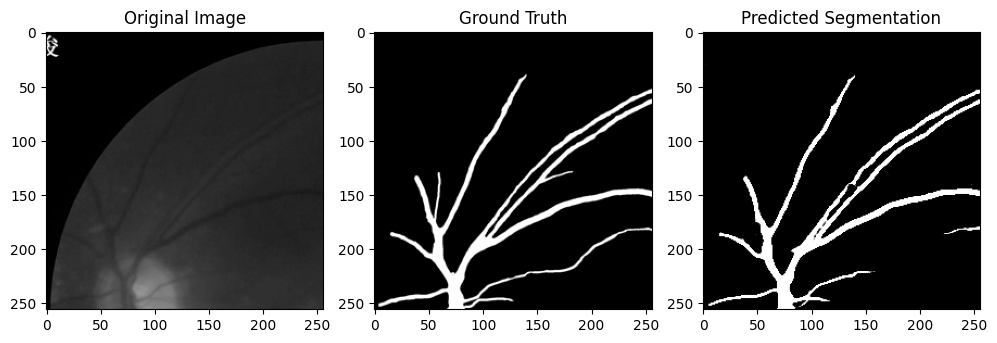

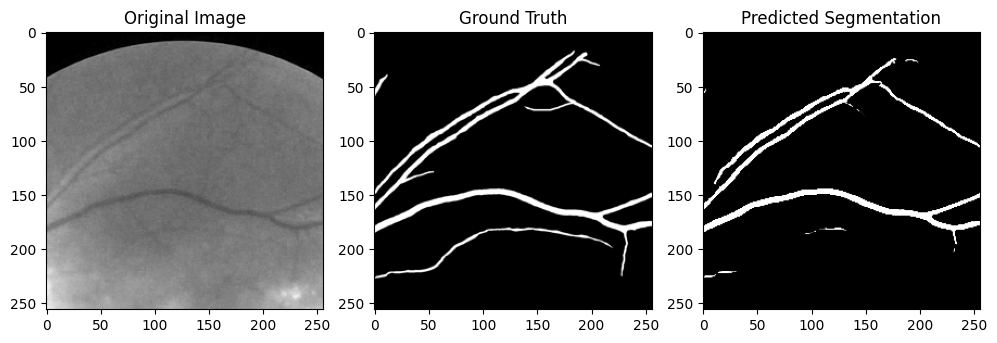

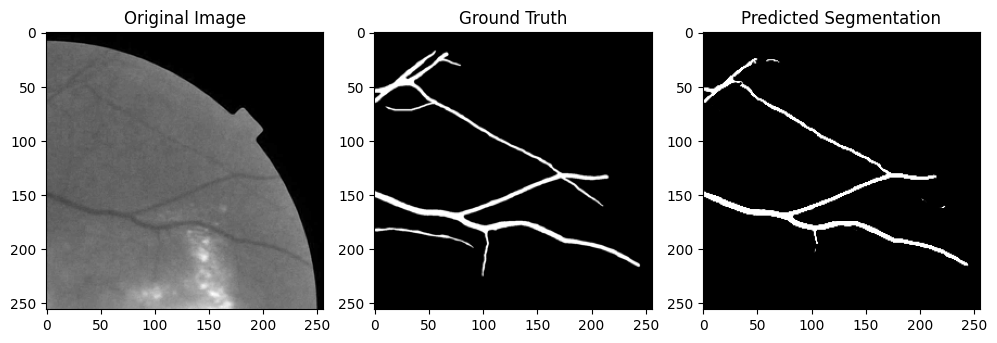

In [ ]:
import matplotlib.pyplot as plt

def visualize_segmentation(test_loader, model, device, num_images=3):
    model.eval()

    with torch.no_grad():
        # Aggiunta di _ per catturare valori aggiuntivi restituiti dal DataLoader
        for i, (images, masks, _) in enumerate(test_loader):
            if i >= num_images:
                break

            images, masks = images.to(device), masks.to(device)
            outputs = torch.sigmoid(model(images))
            outputs = outputs.squeeze()

            for j in range(images.size(0)):
                if i * images.size(0) + j >= num_images:
                    break

                plt.figure(figsize=(10, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(images[j, 0].cpu().squeeze(), cmap='gray')
                plt.title('Original Image')

                plt.subplot(1, 3, 2)
                plt.imshow(masks[j].cpu().squeeze(), cmap='gray')
                plt.title('Ground Truth')

                plt.subplot(1, 3, 3)
                plt.imshow(outputs[j].cpu().squeeze(), cmap='gray')
                plt.title('Predicted Segmentation')

                plt.tight_layout()
                plt.show()

# Visualize segmentation results
visualize_segmentation(test_loader, model, device)



 -- -- -- -- -- RICOSTRUZIONE PATCHES -- -- -- -- --

In [ ]:
from PIL import Image
import numpy as np
import os

def reconstruct_with_overlap(patch_files, patch_size, image_size, overlap, patches_directory, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    step_size = patch_size - overlap  # Calcola lo step size basandosi sull'overlap
    num_patches_x = (image_size - overlap) // step_size
    num_patches_y = (image_size - overlap) // step_size
    patches_per_image = num_patches_x * num_patches_y

    for i in range(0, len(patch_files), patches_per_image):
        image_patches = patch_files[i:i+patches_per_image]
        image_name = "_".join(image_patches[0].split('_')[:-3]) + '.png'
        reconstructed_image = np.zeros((image_size, image_size), dtype=np.float32)
        count_matrix = np.zeros((image_size, image_size), dtype=np.float32) + 1e-6  # Evita la divisione per zero

        for patch_file in image_patches:
            patch_path = os.path.join(patches_directory, patch_file)
            patch = np.array(Image.open(patch_path), dtype=np.float32)
            _, x_str, y_str = patch_file.split('_')[-3:]
            x, y = int(x_str), int(y_str.split('.')[0])

            reconstructed_image[y:y+patch_size, x:x+patch_size] += patch
            count_matrix[y:y+patch_size, x:x+patch_size] += 1

        # Fai la media dei valori nei punti di overlap
        reconstructed_image /= count_matrix

        # Converti l'array numpy in un'immagine PIL e salva
        reconstructed_image_pil = Image.fromarray(np.uint8(reconstructed_image))
        save_path = os.path.join(save_directory, image_name)
        reconstructed_image_pil.save(save_path)

# Parametri
base_directory = '/content/drive/MyDrive/Progetto/RETINA/DL_masks256over'
save_base_directory = '/content/drive/MyDrive/Progetto/RETINA/reconstructed512'
patch_size = 256
image_size = 512
overlap = 128

# Esegue la ricostruzione per ogni subset
for subset in ['train', 'val', 'test']:
    patches_directory = os.path.join(base_directory, subset)
    save_directory = os.path.join(save_base_directory, subset)
    patch_files = sorted([file for file in os.listdir(patches_directory) if file.endswith('.png')])

    reconstruct_with_overlap(patch_files, patch_size, image_size, overlap, patches_directory, save_directory)


-- -- -- -- -- CALCOLO DELLE METRICHE -- -- -- -- --

In [ ]:
def calculate_metrics(mask_gt, reconstructed_mask):
    intersection = np.logical_and(mask_gt, reconstructed_mask)
    union = np.logical_or(mask_gt, reconstructed_mask)
    iou = np.sum(intersection) / np.sum(union)
    accuracy = np.sum(mask_gt == reconstructed_mask) / mask_gt.size
    precision = np.sum(intersection) / np.sum(reconstructed_mask)
    sensitivity = np.sum(intersection) / np.sum(mask_gt)
    dice = 2 * np.sum(intersection) / (np.sum(mask_gt) + np.sum(reconstructed_mask))
    return iou, accuracy, precision, sensitivity, dice

In [ ]:
from PIL import Image
from skimage.io import imread
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray, rgba2rgb
import numpy as np
import os

base_path = '/content/drive/MyDrive/Progetto/RETINA'

# Percorsi alle cartelle con le maschere ground truth e le maschere ricostruite
gt_masks_folders = {
    'train': os.path.join(base_path, 'training', 'train_y'),
    'val': os.path.join(base_path, 'validation', 'validation_y'),
    'test': os.path.join(base_path, 'test', 'test_y')
}
reconstructed_masks_folders = {
    'train': os.path.join(base_path, 'reconstructed512', 'train'),
    'val': os.path.join(base_path, 'reconstructed512', 'val'),
    'test': os.path.join(base_path, 'reconstructed512', 'test')
}


# Dizionario per memorizzare le metriche
metrics = {phase: {'iou': [], 'accuracy': [], 'precision': [], 'sensitivity': [], 'dice': []}
           for phase in ['train', 'val', 'test']}

# Contatore per gli elementi non presi
missing_elements_count = {'train': 0, 'val': 0, 'test': 0}

def prepare_image(path):
    """
    Carica un'immagine, la converte in scala di grigi se necessario, e la ridimensiona.
    """
    image = imread(path)
    if image.shape[-1] == 4:
        image = rgba2rgb(image)
    if len(image.shape) > 2:
        image = rgb2gray(image)
    image_resized = resize(image, (512, 512), anti_aliasing=True)
    image_bin = image_resized > 0.5
    return image_bin

for phase in ['train', 'val', 'test']:
    gt_masks_folder = gt_masks_folders[phase]
    reconstructed_masks_folder = reconstructed_masks_folders[phase]

    reconstructed_filenames_set = {os.path.splitext(fname.replace('_patch', ''))[0] for fname in os.listdir(reconstructed_masks_folder) if fname.endswith('.png')}

    for fname in os.listdir(gt_masks_folder):
        if not fname.endswith('.png') or fname == "448_G.png":
            continue

        base_fname = os.path.splitext(fname)[0]

        if base_fname in reconstructed_filenames_set:
            ground_truth_path = os.path.join(gt_masks_folder, fname)
            reconstructed_mask_path = os.path.join(reconstructed_masks_folder, base_fname + '.png')

            mask_gt = prepare_image(ground_truth_path)
            reconstructed_mask = prepare_image(reconstructed_mask_path)

            iou, accuracy, precision, sensitivity, dice = calculate_metrics(mask_gt, reconstructed_mask)

            metrics[phase]['iou'].append(iou)
            metrics[phase]['accuracy'].append(accuracy)
            metrics[phase]['precision'].append(precision)
            metrics[phase]['sensitivity'].append(sensitivity)
            metrics[phase]['dice'].append(dice)
        else:
            missing_elements_count[phase] += 1


def print_metrics(metrics):
    for phase in ['train', 'val', 'test']:
        print(f"Metrics for {phase.upper()} phase:")
        for metric_name, metric_values in metrics[phase].items():
            if metric_values:  # Verifica che la lista non sia vuota
                mean_value = np.mean(metric_values)
                std_value = np.std(metric_values)
                print(f"{metric_name.capitalize()}: mean = {mean_value:.4f} +/- {std_value:.4f}")
            else:
                print(f"{metric_name.capitalize()}: No data")
        print()  # Aggiunge una riga vuota per separare le fasi

# Utilizza questa funzione modificata per stampare le metriche con media e deviazione standard
print_metrics(metrics)




Metrics for TRAIN phase:
Iou: mean = 0.8204 +/- 0.1177
Accuracy: mean = 0.9862 +/- 0.0114
Precision: mean = 0.9142 +/- 0.0738
Sensitivity: mean = 0.8844 +/- 0.1231
Dice: mean = 0.8953 +/- 0.0958

Metrics for VAL phase:
Iou: mean = 0.8465 +/- 0.0560
Accuracy: mean = 0.9871 +/- 0.0044
Precision: mean = 0.9416 +/- 0.0198
Sensitivity: mean = 0.8951 +/- 0.0680
Dice: mean = 0.9158 +/- 0.0345

Metrics for TEST phase:
Iou: mean = 0.8079 +/- 0.1043
Accuracy: mean = 0.9864 +/- 0.0046
Precision: mean = 0.9177 +/- 0.0455
Sensitivity: mean = 0.8681 +/- 0.1048
Dice: mean = 0.8895 +/- 0.0735



In [ ]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray, rgba2rgb
import numpy as np
import os

base_path = '/content/drive/MyDrive/Progetto/RETINA'

# Percorsi alle cartelle con le maschere ground truth e le maschere ricostruite
gt_masks_folders = {
    'train': os.path.join(base_path, 'training', 'train_y'),
    'val': os.path.join(base_path, 'validation', 'validation_y'),
    'test': os.path.join(base_path, 'test', 'test_y')
}
reconstructed_masks_folders = {
    'train': os.path.join(base_path, 'reconstructed512', 'train'),
    'val': os.path.join(base_path, 'reconstructed512', 'val'),
    'test': os.path.join(base_path, 'reconstructed512', 'test')
}

# Dizionario per memorizzare le metriche aggregate
aggregated_metrics = {'iou': [], 'accuracy': [], 'precision': [], 'sensitivity': [], 'dice': []}

def prepare_image(path):
    """
    Carica un'immagine, la converte in scala di grigi se necessario, e la ridimensiona.
    """
    image = imread(path)
    if image.shape[-1] == 4:
        image = rgba2rgb(image)
    if len(image.shape) > 2:
        image = rgb2gray(image)
    image_resized = resize(image, (512, 512), anti_aliasing=True)
    image_bin = image_resized > 0.5  # Soglia per binarizzazione
    return image_bin

for phase in ['train', 'val', 'test']:
    gt_masks_folder = gt_masks_folders[phase]
    reconstructed_masks_folder = reconstructed_masks_folders[phase]

    reconstructed_filenames_set = {os.path.splitext(fname.replace('_patch', ''))[0] for fname in os.listdir(reconstructed_masks_folder) if fname.endswith('.png')}

    for fname in os.listdir(gt_masks_folder):
        if not fname.endswith('.png') or fname == "448_G.png":
            continue

        base_fname = os.path.splitext(fname)[0]

        if base_fname in reconstructed_filenames_set:
            ground_truth_path = os.path.join(gt_masks_folder, fname)
            reconstructed_mask_path = os.path.join(reconstructed_masks_folder, base_fname + '.png')

            mask_gt = prepare_image(ground_truth_path)
            reconstructed_mask = prepare_image(reconstructed_mask_path)

            iou, accuracy, precision, sensitivity, dice = calculate_metrics(mask_gt, reconstructed_mask)

            # Aggiungi i risultati sia alle metriche aggregate
            aggregated_metrics['iou'].append(iou)
            aggregated_metrics['accuracy'].append(accuracy)
            aggregated_metrics['precision'].append(precision)
            aggregated_metrics['sensitivity'].append(sensitivity)
            aggregated_metrics['dice'].append(dice)

def print_aggregated_metrics(metrics):
    print("Metrics for ALL PHASES combined:")
    for metric_name, metric_values in metrics.items():
        if metric_values:  # Verifica che la lista non sia vuota
            mean_value = np.mean(metric_values)
            std_value = np.std(metric_values)
            print(f"{metric_name.capitalize()}: mean = {mean_value:.4f} +/- {std_value:.4f}")
        else:
            print(f"{metric_name.capitalize()}: No data")
    print()  # Aggiunge una riga vuota per separare le sezioni

# Stampa le metriche aggregate
print_aggregated_metrics(aggregated_metrics)


Metrics for ALL PHASES combined:
Iou: mean = 0.8211 +/- 0.1115
Accuracy: mean = 0.9863 +/- 0.0101
Precision: mean = 0.9175 +/- 0.0671
Sensitivity: mean = 0.8830 +/- 0.1163
Dice: mean = 0.8965 +/- 0.0886



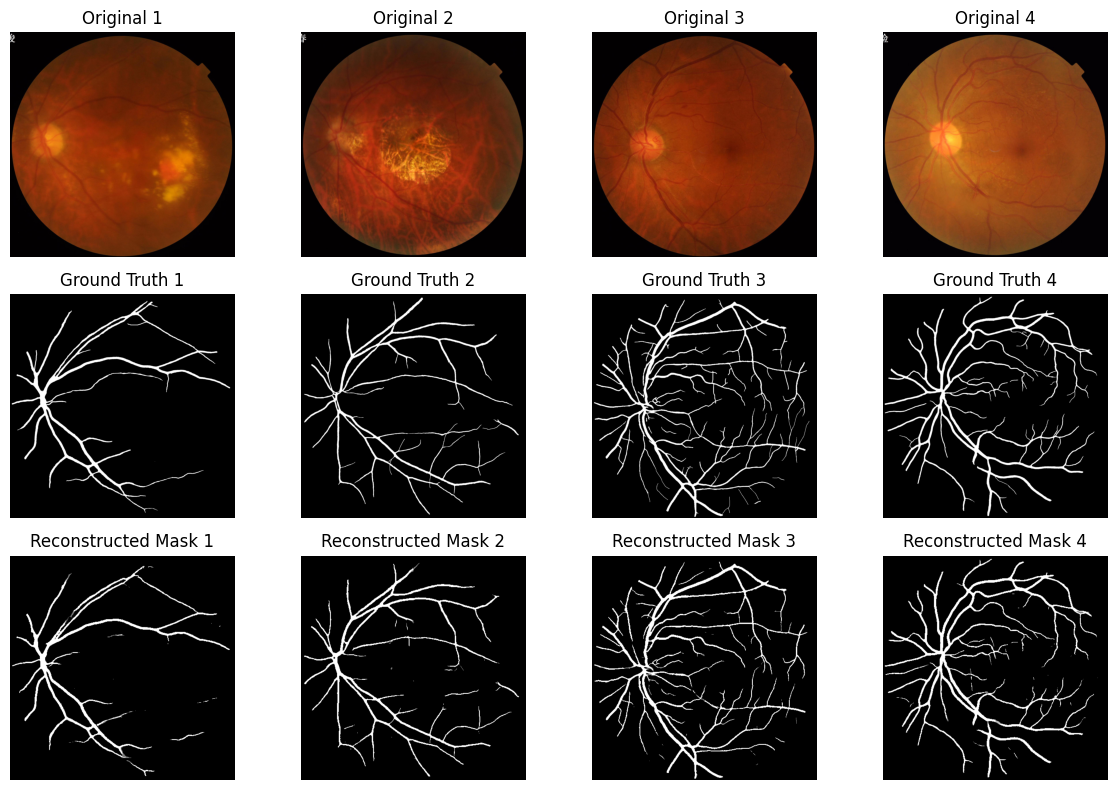

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Assumendo che i file siano stati caricati e che le loro directory siano state impostate correttamente
original_images_dir = '/content/drive/MyDrive/Progetto/RETINA/test/test_x'
ground_truth_dir = '/content/drive/MyDrive/Progetto/RETINA/test/test_y'
reconstructed_masks_dir = '/content/drive/MyDrive/Progetto/RETINA/reconstructed512/test'

# Prendi i primi quattro file di ogni directory (assumendo che i file siano ordinati correttamente)
original_images_files = sorted(os.listdir(original_images_dir))[:4]
ground_truth_files = sorted(os.listdir(ground_truth_dir))[:4]
reconstructed_masks_files = sorted(os.listdir(reconstructed_masks_dir))[:4]

# Crea una figura con subplot per le 12 immagini (3 per ogni categoria)
plt.figure(figsize=(12, 8))

for i in range(4):
    # Immagine originale RGB
    plt.subplot(3, 4, i + 1)
    original_image = Image.open(os.path.join(original_images_dir, original_images_files[i]))
    plt.imshow(original_image)
    plt.title(f'Original {i+1}')
    plt.axis('off')

    # Ground truth
    plt.subplot(3, 4, i + 5)
    ground_truth_image = Image.open(os.path.join(ground_truth_dir, ground_truth_files[i]))
    plt.imshow(ground_truth_image, cmap='gray')
    plt.title(f'Ground Truth {i+1}')
    plt.axis('off')

    # Maschera ricostruita
    plt.subplot(3, 4, i + 9)
    reconstructed_mask = Image.open(os.path.join(reconstructed_masks_dir, reconstructed_masks_files[i]))
    plt.imshow(reconstructed_mask, cmap='gray')
    plt.title(f'Reconstructed Mask {i+1}')
    plt.axis('off')

# Mostra il plot
plt.tight_layout()
plt.show()
